# WandB

In [1]:
import wandb

# Change directory to parent folder

In [2]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(os.path.dirname(cwd)).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(os.path.dirname(cwd)) # parent directory
os.chdir(new_cwd)

# Imports

In [3]:
# show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
import os
import json

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import RNN, train_one_epoch, eval_model, compute_loss, outs2df, compute_metrics

from Abstention.utils import plot_reliability,get_prediction_thresholds,ece

from config import Settings; settings = Settings()


import torch
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import ParameterGrid, ParameterSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wandb

# Model reproducibility

In [7]:
# Reproducibility
seed = settings.random_seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load dataset

In [8]:
dataset_id = 'diag_only'
dataset_folder = os.path.join(settings.data_base,settings.model_ready_dataset_folder,dataset_id)
print('dataset at',dataset_folder)

dataset at data/model_ready_dataset/diag_only


In [9]:
grouping = 'ccs' # coding-scheme
batch_size=64

dataset = DiagnosesDataset(os.path.join(dataset_folder,'dataset.json'),grouping)

train_dataset = DiagnosesDataset(os.path.join(dataset_folder,'train_subset.json'),grouping)
val_dataset = DiagnosesDataset(os.path.join(dataset_folder,'val_subset.json'),grouping)
test_dataset = DiagnosesDataset(os.path.join(dataset_folder,'test_subset.json'),grouping)


len(train_dataset)
len(val_dataset)
len(test_dataset)


train_dataloader = DataLoader(train_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset),shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset)) #batch_size here is arbitrary and doesn't affect total validation speed
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset))

5249

1125

1125

# Train model

Define hyper-parameters

In [10]:
# remaining hyperparameters of best model
input_size = next(iter(train_dataloader))['target_sequences']['sequence'].shape[2]
hidden_size = 75
num_layers = 1
n_labels = input_size
rnn_type = 'lstm'
model_type ='deterministic'

lr = 0.01
n_labels = input_size
epochs = 15
criterion = torch.nn.BCEWithLogitsLoss()

In [12]:
config = {'seed':seed,
          'input_size':input_size,
          'hidden_size':hidden_size,
          'num_layers':num_layers,
          'n_labels':n_labels,
          'rnn_type':rnn_type,
          'lr':lr,
          'optim':'adam',
          'epochs':epochs,
          'model_type':model_type
         }

and now train

In [14]:
model = RNN(input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            n_labels=n_labels,
            model=rnn_type,
           )
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

# train
for idx,epoch in enumerate(range(1,epochs+1)):
    loss = train_one_epoch(model, train_dataloader, epoch, criterion, optimizer);
    if idx % 5 == 0 or idx == epochs-1:
        print(f"epoch {epoch}\t| loss {loss}\t|") 

epoch 1	| loss 0.18371832110436567	|
epoch 6	| loss 0.11432326441428747	|
epoch 11	| loss 0.10549505853868392	|
epoch 15	| loss 0.09888887634298887	|


# Generate predictions

In [15]:
# Get model outputs for train and validation sets
train_logits, train_golden = outs2df(model,train_dataloader,dataset,return_golden=True)
val_logits, val_golden = outs2df(model,val_dataloader,dataset,return_golden=True)

# Compute prediction threshold. Based on ROC geometric mean from training set
thresholds = get_prediction_thresholds(train_logits,train_golden)

def predict(predictions: pd.Series, threshold : float):
    return predictions.apply(lambda x: 1 if x > threshold else 0)

train_predictions = train_logits.apply(lambda x: predict(x,thresholds.loc[x.name,'threshold']),axis=0)
val_predictions = val_logits.apply(lambda x: predict(x,thresholds.loc[x.name,'threshold']),axis=0)

train_predictions.shape
val_predictions.shape

(8591, 272)

(1943, 272)

# Generate train vs. validation metrics

In [16]:
metrics=['roc','recall','precision','accuracy']

train_metrics = eval_model(model,train_dataloader,dataset,metrics,name='train set')[1].filter(regex='_adm')
val_metrics = eval_model(model,val_dataloader,dataset,metrics,name='validation set')[1].filter(regex='_adm')

results = pd.concat([train_metrics,val_metrics],axis=1)
results

,train set,validation set
metrics,,
roc_adm,0.943836,0.919903
accuracy_adm,0.827438,0.764958
recall_adm,0.743267,0.671595
precision_adm,0.215437,0.145489


# Generate ECE

In [29]:
def ECE(logits : pd.DataFrame, preds : pd.DataFrame, golden : pd.DataFrame,nbins=10):
    
    """
    Computes Expected Calibration Error (ECE) of a model on a set of data with known labels.
    
    Parameters
    ----------
    
    logits : pd.DataFrame, index = (pat_id,adm_index), columns = (diag_0,...diag_X)
        DataFrame with probability output of the model for each label on each patient's admission
    
    preds : pd.DataFrame, index = (pat_id,adm_index), columns = (diag_0,...diag_X)
        DataFrame with the prediction of the model for each label on each patient's admission
    
    golden : pd.DataFrame, index = (pat_id,adm_index), columns = (diag_0,...diag_X)
        DataFrame of golden labels on each patient's admission
        
        
    Returns
    -------
    
    ece : np.array, size=(0,N) with N equal to the nº of columns in logits/preds/golden dataframes.
    """
    
    # confidence of predicted class
    confidences = logits.where(preds==1,1-logits)

    accuracies = preds == golden.to_numpy()
    ece = np.zeros(shape=(accuracies.shape[1],))

    bins = np.linspace(0,1,nbins+1)

    control = np.zeros(shape=(accuracies.shape[1]))

    for left,right in zip(bins[:-1],bins[1:]):
        in_bin = ((confidences > left) & (confidences < right)).values

        avg_acc_in_bin = accuracies[in_bin].mean(axis=0).to_numpy()
        avg_confidence_in_bin = confidences[in_bin].mean(axis=0).to_numpy()

        weight = in_bin.sum(axis=0) / preds.shape[0]

        ece += weight * np.abs(avg_acc_in_bin - avg_confidence_in_bin)
    return ece

In [ ]:
ece_train

In [27]:
ece_train = ECE(train_logits,train_predictions,train_golden)
ece_validation = ECE(val_logits,val_predictions,val_golden)

In [30]:
pd.Series(ece_train).describe()[['mean','std']]
pd.Series(ece_validation).describe()[['mean','std']]

mean    0.004335
std     0.005303
dtype: float64

mean    0.006303
std     0.009733
dtype: float64

ECE seems way too good (low). Let's test abstention through simply thresholds on confidence

# Baseline abstention

In [31]:
def abstention_profile_wandb(logits, preds, golden, set_name, threshold_method, metrics, wandb_config):
    """
    
    Saves abstention run on wandb project "thesis_baseline_abstention".
    
    Parameters
    ----------
    logits : pd.DataFrame, index = (pat_id, adm_index), columns = (diag_0,...diag_X)
    
    preds : pd.DataFrame, index = (pat_id, adm_index), columns = (diag_0,...diag_X)
    
    golden : pd.DataFrame, index = (pat_id, adm_index), columns = (diag_0,...diag_X)
    
    set_name : str
        Name of the dataset. usually it's "train" or "validation"
        
    threshold_method : str
        Method used to obtain thresholds to perform predictions
    
    metrics : List<str> 
        metrics to log. Must be a subset of ['recall', 'precision', 'f1', 'accuracy', 'roc']
    """
    
    AWAITING_VALUE = 'awaiting value'
    wandb.init(project="thesis_baseline_abstention", entity="snovaisg",config=wandb_config)
    
    roc = -1
    if 'roc' in metrics:
        roc = AWAITING_VALUE

    # algorithm
    all_res = list()
    
    # abstention thresholds
    abst_thresholds = np.linspace(0,1,11)[:-1]
    for idx,th in enumerate(abst_thresholds):
        
        if roc != -1 and roc != AWAITING_VALUE and 'roc' in metrics: # add roc. optimized to not have to compute it everytime
            metrics.remove('roc')

        mask_below_threshold = logits < th

        preds_after_abstention = preds.mask(mask_below_threshold,0)

        #count diagnostics abstained in total
        total_abstained = (preds - preds_after_abstention).sum(axis=0).sum()

        # count admissions with no prediction now
        total_adms_no_prediction = (preds_after_abstention.sum(axis='columns') == 0).sum()

        # statistics of mean and std diagnostics predicted on each admission
        adm_stats = preds_after_abstention.sum(axis='columns').describe()[['mean','std']]
        adm_stats.index = [e + " diagnostics predicted" for e in adm_stats.index]


        res = compute_metrics(logits,preds_after_abstention,golden,metrics = metrics).filter(regex='_adm')
        res.loc['#P->N'] = total_abstained
        res.loc['adms w/ prediction'] = total_adms_no_prediction
        res.loc['threshold'] = round(th,2)
        
        if roc != -1 and roc != AWAITING_VALUE: # add roc. optimized to not have to compute it everytime
            res.loc['roc_adm'] = roc
        
        if roc == AWAITING_VALUE: # add roc. optimized to not have to compute it everytime
            roc = res.loc['roc_adm']
            
        res = res.append(adm_stats)

        res.name = None
        all_res.append(res)
        
        # wandb
        
        log = res.to_dict()
        log['set'] = set_name
        wandb.log(log)

        print(f'{idx+1}/{len(abst_thresholds)} Done')
    wandb.finish(quiet=True)
    return all_res


In [ ]:
metrics = ['recall','precision','f1','accuracy','roc']
threshold_method = 'roc gm (train)'
profile_validation = abstention_profile_wandb(val_logits, val_predictions, val_golden, 'validation', threshold_method, metrics,config)
profile_train = abstention_profile_wandb(train_logits, train_predictions, train_golden, 'train', threshold_method, metrics,config)

In [21]:
res.to_dict()
log = res.to_dict()


{'roc_adm': 0.9512533707162892,
 'accuracy_adm': 0.8451551412644266,
 'recall_adm': 0.7723060935831192,
 'precision_adm': 0.24031384228240754,
 'f1_adm': 0.3570273494494896,
 '#P->N': 0.0,
 'adms w/ prediction': 0.0,
 'threshold': 0.0,
 'mean diagnostics predicted': 43.758817367011986,
 'std diagnostics predicted': 22.38208338222873}

In [66]:
# metrics
#metrics = ['recall','precision','f1','accuracy']
metrics = ['precision','recall','f1','roc','accuracy']

# abstention thresholds
abst_thresholds = np.linspace(0,1,11)[:-1]

#inputs
logits = train_logits.copy()
preds = train_predictions.copy()
golden = train_golden.copy()

# algorithm
all_res = list()

for idx,th in enumerate(abst_thresholds):
    
    mask_below_threshold = logits < th
    
    preds_after_abstention = preds.mask(mask_below_threshold,0)
    
    #count diagnostics abstained in total
    total_abstained = (preds - preds_after_abstention).sum(axis=0).sum()
    
    # admissions with no prediction now
    total_adms_no_prediction = (preds_after_abstention.sum(axis='columns') == 0).sum()
    
    # statistics of mean and std diagnostics predicted on each admission
    adm_stats = preds_after_abstention.sum(axis='columns').describe()[['mean','std']]
    adm_stats.index = [e + " diagnostics predicted" for e in adm_stats.index]
    
    
    res = compute_metricsV3(logits,preds_after_abstention,golden,metrics = metrics).filter(regex='_adm')
    res.loc['#P->N'] = total_abstained
    res.loc['adms w/ prediction'] = total_adms_no_prediction
    res.loc['threshold'] = round(th,2)
    res = res.append(adm_stats)
    
    res.name = None
    all_res.append(res)
    
    print('done')
    

done
done
done
done
done
done
done
done
done
done


In [74]:
df = pd.concat(all_res,axis=1).T.set_index('threshold')
df.index = [round(t,2) for t in df.index]
df.index.name = 'threshold'
df

,accuracy_adm,recall_adm,precision_adm,f1_adm,#P->N,adms w/ prediction,mean diagnostics predicted,std diagnostics predicted
threshold,,,,,,,,
0.0,0.845155,0.772306,0.240314,0.357027,0.0,0.0,43.758817,22.382083
0.1,0.934304,0.700844,0.442253,0.527127,200393.0,1.0,20.432895,10.676375
0.2,0.952708,0.607482,0.562337,0.566418,258215.0,4.0,13.702363,7.411927
0.3,0.958686,0.515573,0.648790,0.555525,290393.0,29.0,9.956815,5.555928
0.4,0.960218,0.426455,0.723674,0.516115,313218.0,83.0,7.299965,4.365144
0.5,0.959620,0.348007,0.779128,0.460780,329124.0,176.0,5.448493,3.429125
0.6,0.957858,0.276699,0.816490,0.394137,341146.0,359.0,4.049121,2.727032
0.7,0.955376,0.207699,0.825309,0.315934,351124.0,754.0,2.887673,2.130618
0.8,0.952479,0.138354,0.770661,0.223736,360161.0,1709.0,1.835758,1.603374


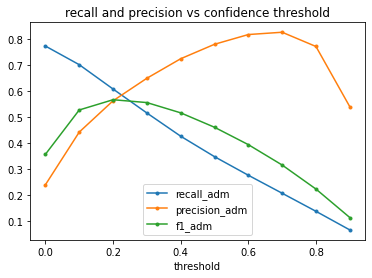

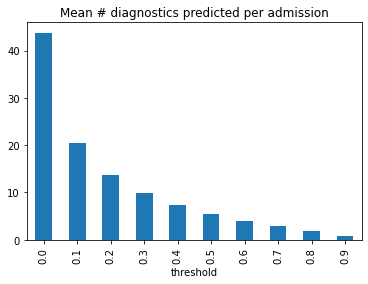

In [88]:
df[['recall_adm','precision_adm','f1_adm']].plot.line(title='recall and precision vs confidence threshold', marker='.')
plt.show()
df['mean diagnostics predicted'].plot.bar(title='Mean # diagnostics predicted per admission');

----

For a single

In [45]:
# abstention thresholds
abst_thresholds = np.linspace(0,1,11)[3:-1]

# Get a prediction for an admission
for th in abst_thresholds:
    # single admission to test this out
    adm_preds = train_predictions.iloc[0,:]
    adm_logits = train_logits.iloc[0,:]
    
    # get its predictions
    positive_preds = adm_preds[adm_preds == 1].index
    
    # get the preds below threshold
    below_threshold = adm_logits[(adm_logits < th)].index
    
    # predictions after abstention
    preds_after_abst = [p for p in positive_preds if p now in below_threshold]
    
    # count the abstained diagnostics
    abst_count = len(positive_preds) - len(preds_after_abst)

    # recompute metrics

Index(['diag_0', 'diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5', 'diag_6',
       'diag_7', 'diag_8', 'diag_9',
       ...
       'diag_262', 'diag_263', 'diag_264', 'diag_265', 'diag_266', 'diag_267',
       'diag_268', 'diag_269', 'diag_270', 'diag_271'],
      dtype='object', length=269)

# Other

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score,average_precision_score,recall_score,precision_score,f1_score,accuracy_score